## Reproduction code for the noiseless-data setting

This notebook contains the code for reproducing the numerical results under the noiseless-data setting in the paper *Simultaneous activity and attenuation estimation
in TOF-PET with TV-constrained nonconvex
optimization*. In specific, the code in this notebook reproduces Figure 1 and Figure 3-8 of the paper.


We start from loading the libraries necessary for running the code.

In [217]:
from numpy import *
import numpy as np
svd = linalg.svd
randn = random.randn
import numba
from numba import njit
from pylab import *
ion()
import scipy
from scipy import ndimage

Load the test images stored under the directory `"./data/"`. Here, `testmu` is the ground-truth attenuation map and `testlambda` is the ground-truth activity map. We plot the two ground-truth maps, reproducing Figure 1.

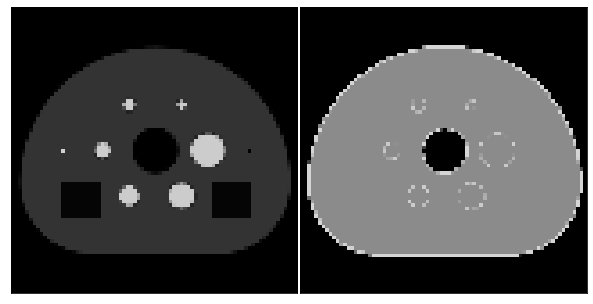

In [218]:
# Load the test images
testmu = load("./data/UWDRO1_slice40_attenuation.npy")[::2,::2]*1.
testlambda = load("./data/UWDRO1_slice40_activity.npy")[::2,::2]*1.


# Plot the ground-truth maps
gf = ndimage.gaussian_filter
im1 = gf(np.load("./data/UWDRO1_slice40_activity.npy"),0.0)[::2,::2]
im2 = gf(np.load("./data/UWDRO1_slice40_attenuation.npy"),0.0)[::2,::2]
vmm1= 0.0
vmx1= 40000
vmm2= 0.075
vmx2= 0.115
figure(1,figsize=(8,4))
subplot(121)
imshow(im1[24:104,24:104],vmin = vmm1, vmax = vmx1, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(122)
imshow(im2[24:104,24:104],vmin = vmm2, vmax = vmx2, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0,top = 1,right= 1,wspace =0.01)

Both the activity map and the attenuation map are of size $30\times30$ $\text{cm}^2$, and are discretized  into $128\times 128$ pixels. The activity map is normalized such that the expected total number of counts is $1.0\times 10^6$. There are $128\times 128$ pairs of detectors in the system, where the lines-of-response (LORs) are organized in parallel-ray fashion; the distance between a pair of two detectors is $200$ cm. The TOF window sensitivity along the LOR is specified by $$w_i(t) = \exp(-(t-t_i)^2/(2\sigma_{\text{TOF}})).$$ The full-width-half-maximum (FWHM) is $2\sqrt{2\log 2}\sigma_{\text{TOF}}$, and is taken to be $9$ cm in our simulation.

In [219]:
## Parameters of the images
totalcounts = 1.0e6 # expected total number of counts
nx = 128 
ny = 128
ximageside = 30.0   #cm
yimageside = 30.0   #cm
dx = ximageside/nx
dy = yimageside/ny
xar=arange(-ximageside/2. + dx/2 , ximageside/2., dx)[:,newaxis]*ones([nx])
yar=ones([nx,ny])*arange(-yimageside/2. + dy/2 , yimageside/2., dy)
rar=sqrt(xar**2 + yar**2)
fovmask = testlambda*0.
fovmask[rar<=ximageside/2.] = 1. #the fovmask confines the image to the largest inscribed circle of the image array
mumask = fovmask*1.

## Parameters of the detectors
radius = 100.0    #cm
detector1_to_detector2 = 200.0   #cm
nviews = 128
slen = pi     #angular range of the scan
nbins = 128
dtc = dx/16.
ntc = int(detector1_to_detector2/dtc)
tcshift = 0.5*(detector1_to_detector2 - ntc*dtc)
war = arange(radius-detector1_to_detector2+tcshift,radius,dtc)

## Time-of-flight information
fwhm = 9.0 #cm
tofspacing = fwhm/2.
toflen = ximageside+2*fwhm
toflen = minimum(toflen,detector1_to_detector2)
tofsig= fwhm/2.355
dtof = tofspacing
ntof = int(toflen/dtof)
toflen = ntof*dtof    #change the toflen so that it is a multiple of dtof
tof0 = -toflen/2.
tofmat = []
for i in range(ntof):
   w0 = (i+0.5)*dtof + tof0
   wfun = exp( -((war-w0)**2)/(2.*tofsig**2))
   tofmat.append(wfun)
tofmat = array(tofmat)

## Additional parameters
small = 1.e-10 # small constant to avoid numerical error


The following code contains utility functions essential for running the code.

In [220]:
## function for forward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamProjection(wimage,sinogram, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   image = mask*wimage
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for backward projection
@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamBackProjection(sinogram, image, mask = mumask,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen
               ixOld=ix
               xIntOld=xIntercept
   image *= mask


## function for weighted forward projection
@njit(cache=True) # if computing projection multiple times use: @njit(cache=true)
def circularParallelBeamWProjection(image,sinogram, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   sinogram.fill(0.)
   
   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.


   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensues ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            raysum=0.
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     raysum = raysum+tofweight2*frac1*travPixlen*image[ix,iyOld]
                  if ((iy>=0) and (iy<ny)):
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            raysum=0.
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     raysum=raysum+tofweight1*travPixlen*image[ix,iy]
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     raysum=raysum+tofweight2*frac1*travPixlen*image[ixOld,iy]
                  if ((ix>=0) and (ix<nx)) :
                     raysum=raysum+tofweight1*frac2*travPixlen*image[ix,iy]
               ixOld=ix
               xIntOld=xIntercept
         sinogram[sindex,uindex]=raysum

## function for weighted backward projection

@njit(cache=True) # If computing projection multiple times use: @njit(cache=True)
def circularParallelBeamWBackProjection(sinogram, image, weighting, dtc = dtc, tcshift = tcshift,
                              nx = nx, ny = ny, ximageside = ximageside, yimageside = yimageside,
                              radius = radius, detector1_to_detector2 = detector1_to_detector2,
                              nviews = nviews, slen = slen, nbins = nbins):

   image.fill(0.)

   dx = ximageside/nx
   dy = yimageside/ny
   x0 = -ximageside/2.
   y0 = -yimageside/2.

   #compute length of detector so that it views the inscribed FOV of the image array
   detectorlength = ximageside   # This only works for ximageside = yimageside
   u0 = -detectorlength/2.

   du = detectorlength/nbins
   ds = slen/nviews

   for sindex in range(nviews):
#      print("Doing view number: ",sindex)   #UNCOMMENT if you want to see view progress
      s = sindex*ds
# detector1 center
      xDet1Center=radius*cos(s)
      yDet1Center=radius*sin(s)

# detector2 center
      xDet2Center=(radius - detector1_to_detector2)*cos(s)
      yDet2Center=(radius - detector1_to_detector2)*sin(s)

# unit vector in the direction of the detector line
      eux = -sin(s)
      euy =  cos(s)

# Unit vector in the direction perpendicular to the detector line
      ewx = cos(s)
      ewy = sin(s)

      for uindex in range(nbins):
         sinoval = sinogram[sindex,uindex]

         u = u0+(uindex+0.5)*du
         xbin1 = xDet1Center + eux*u
         ybin1 = yDet1Center + euy*u

         xbin2 = xDet2Center + eux*u
         ybin2 = yDet2Center + euy*u

         xl=x0
         yl=y0

         xdiff=xbin2-xbin1
         ydiff=ybin2-ybin1
         xad=abs(xdiff)*dy
         yad=abs(ydiff)*dx

         if (xad>yad):   # loop through x-layers of image if xad>yad. This ensures ray hits only one or two pixels per layer
            slope=ydiff/xdiff
            travPixlen=dx*sqrt(1.0+slope*slope)
            yIntOld=ybin1+slope*(xl-xbin1)
            iyOld=int(floor((yIntOld-y0)/dy))
            for ix in range(nx):
               x=xl+dx*(ix + 1.0)
               yIntercept=ybin1+slope*(x-xbin1)
               iy=int(floor((yIntercept-y0)/dy))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               ymid = yl+dy*(iyOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if iy == iyOld: # if true, ray stays in the same pixel for this x-layer
                  if ((iy >= 0) and (iy < ny)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:    # else case is if ray hits two pixels for this x-layer
                  yMid=dy*max(iy,iyOld)+yl
                  ydist1=abs(yMid-yIntOld)
                  ydist2=abs(yIntercept-yMid)
                  frac1=ydist1/(ydist1+ydist2)
                  frac2=1.0-frac1
                  if ((iyOld >= 0) and (iyOld < ny)):
                     image[ix,iyOld] =image[ix,iyOld]+frac1*sinoval*travPixlen*tofweight2
                  if ((iy>=0) and (iy<ny)):
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               iyOld=iy
               yIntOld=yIntercept
         else: # loop through y-layers of image if xad<=yad
            slopeinv=xdiff/ydiff
            travPixlen=dy*sqrt(1.0+slopeinv*slopeinv)
            xIntOld=xbin1+slopeinv*(yl-ybin1)
            ixOld=int(floor((xIntOld-x0)/dx))
            for iy in range(ny):
               y=yl+dy*(iy + 1.0)
               xIntercept=xbin1+slopeinv*(y-ybin1)
               ix=int(floor((xIntercept-x0)/dx))

               xmid = xl+dx*(ix + 0.5)
               ymid = yl+dy*(iy + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight1 = weighting[int(tc/dtc)]
               xmid = xl+dx*(ixOld + 0.5)
               tc = sqrt( (xmid-xbin1)**2 + (ymid-ybin1)**2 ) -tcshift
               tofweight2 = weighting[int(tc/dtc)]
               
               if (ix == ixOld): # if true, ray stays in the same pixel for this y-layer
                  if ((ix >= 0) and (ix < nx)):
                     image[ix,iy] =image[ix,iy]+sinoval*travPixlen*tofweight1
               else:  # else case is if ray hits two pixels for this y-layer
                  xMid=dx*max(ix,ixOld)+xl
                  xdist1=abs(xMid-xIntOld)
                  xdist2=abs(xIntercept-xMid)
                  frac1=xdist1/(xdist1+xdist2)
                  frac2=1.0-frac1
                  if ((ixOld >= 0) and (ixOld < nx)) :
                     image[ixOld,iy] =image[ixOld,iy]+frac1*sinoval*travPixlen*tofweight2
                  if ((ix>=0) and (ix<nx)) :
                     image[ix,iy] =image[ix,iy]+frac2*sinoval*travPixlen*tofweight1
               ixOld=ix
               xIntOld=xIntercept


## functions for time-of-flight projection matrix multiplication

def TOFprojection(wimage,tofsino,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   tofsino.fill(0.)
   image = mask*wimage
   for i in range(ntof):
      circularParallelBeamWProjection(image,tofsino[i],tofmat[i])


def TOFbackProjection(tofsino,image,mask=fovmask,tofmat=tofmat,ntof=ntof,nviews=nviews,nbins=nbins):
   image.fill(0.)
   wim = image*0.
   for i in range(ntof):
      circularParallelBeamWBackProjection(tofsino[i],wim,tofmat[i])
      image += wim
   image *= mask

## utility functions for saatv-admm

#gradient implementations for TV
def gradim(image):

   xgrad = image.copy()
   ygrad = image.copy()
   temp = image
   xgrad[:-1,:] = temp[1:,:] - temp[:-1,:]
   ygrad[:,:-1] = temp[:,1:] - temp[:,:-1]
   xgrad[-1,:] =  -1.0* temp[-1,:]
   ygrad[:,-1] =  -1.0* temp[:,-1]

   return xgrad,ygrad


def mdiv(xgrad,ygrad):
   divim = xgrad.copy()
   shp = [xgrad.shape[0] + 2, xgrad.shape[1] +2]
   xgradp=zeros(shp)
   ygradp=zeros(shp)
   xgradp[1:-1,1:-1] = xgrad*1.
   ygradp[1:-1,1:-1] = ygrad*1.
   divim.fill(0.)
   divim = xgradp[:-2,1:-1] + ygradp[1:-1,:-2] - xgradp[1:-1,1:-1] - ygradp[1:-1,1:-1]

   return divim


def euclidean_proj_simplex(v, s=1):
   """ Compute the Euclidean projection on a positive simplex

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0 

    Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the simplex

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex

    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.

    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # check if we are already on the simplex
   if v.sum() == s and np.alltrue(v >= 0):
      # best projection: itself!
      return v
   # get the array of cumulative sums of a sorted (decreasing) copy of v
   u = np.sort(v)[::-1]
   cssv = np.cumsum(u)
   # get the number of > 0 components of the optimal solution
   rho = np.nonzero(u * np.arange(1, n+1) > (cssv - s))[0][-1]
   # compute the Lagrange multiplier associated to the simplex constraint
   theta = (cssv[rho] - s) / (rho + 1.0)
   # compute the projection by thresholding v using theta
   w = (v - theta).clip(min=0)
   return w


def euclidean_proj_l1ball(v, s=1):
   """ Compute the Euclidean projection on a L1-ball

    Solves the optimisation problem (using the algorithm from [1]):

        min_w 0.5 * || w - v ||_2^2 , s.t. || w ||_1 <= s
   Parameters
    ----------
    v: (n,) numpy array,
       n-dimensional vector to project

    s: int, optional, default: 1,
       radius of the L1-ball

    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the L1-ball of radius s

    Notes
    -----
    Solves the problem by a reduction to the positive simplex case

    See also
    --------
    euclidean_proj_simplex
    """
   assert s > 0, "Radius s must be strictly positive (%d <= 0)" % s
   n, = v.shape  # will raise ValueError if v is not 1-D
   # compute the vector of absolute values
   u = np.abs(v)
   # check if v is already a solution
   if u.sum() <= s:
       # L1-norm is <= s
       return v
   # v is not already a solution: optimum lies on the boundary (norm == s)
   # project *u* on the simplex
   w = euclidean_proj_simplex(u, s=s)
   # compute the solution to the original problem on v
   w *= np.sign(v)
   return w




In this noiseless-data setting, the count data for TOF-window $i$ and LOR $\ell$ is specified as 
$$
C_{i\ell} = \exp(-P_i^\top \mu) \cdot T_{t\ell}^\top \lambda.
$$
The count data is rescaled such that $\sum_{i,\ell}C_{i\ell} = 1.0\times 10^6$.


In [231]:
sinogram=zeros([nviews,nbins],"float64")   
sinoatt = sinogram.copy()
sinoatt.fill(0.)
circularParallelBeamProjection(testmu,sinoatt)
attfactor = exp(-sinoatt)

tofsino = zeros([ntof,nviews,nbins])
TOFprojection(testlambda,tofsino)

truess = tofsino.sum(axis=0)
tofdata = attfactor*tofsino
datafactor = totalcounts/tofdata.sum() #scale the data to the desired count level

tofdata *= datafactor
tofsino *= datafactor
testlambda  *= datafactor
truess *= datafactor

To implement ADMM-TVSAA, we need to compute the largest singular values of $T$ and $P$, i.e., $\|T\|_2$ and $\|P\|_2$. We shall also compute the constraints on the TV-norm of the attenuation map $\mu$ and the activity map $\lambda$, i.e., $\|\mu\|_{\text{TV}}$ and $\|\lambda\|_{\text{TV}}$.

In [232]:
ltofproj = 23.1500763
lproj =27.89508541
numu= 9.92287722
nulam= 8.23497622
ltotmu = 27.973308258
ltotlam = 23.24406084
ptvmu = 100
tgx,tgy = gradim(testmu)
tvmu = numu*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvmu/100.0)
ptvlam = 100
tgx,tgy = gradim(testlambda)
tvlambda = nulam*sqrt(tgx**2 + tgy**2).sum() *(1.*ptvlam/100.0)
ltotalcounts = testlambda.sum()
print("the ground-truth TV constraint for the activity map: ",tvlambda)
print("the ground-truth TV constraint for the attenuation map: ",tvmu)
print("the ground-truth total count constraint for the activity map: ",ltotalcounts)

the ground-truth TV constraint for the activity map:  91316.61969103648
the ground-truth TV constraint for the attenuation map:  319.5319780852521
the ground-truth total count constraint for the activity map:  56559.56349102085


For each algorithm, we set the number of outer loops to be 1001. 
For ADMM-TVSAA, the number of alternating optimization steps is set to be 100, and the 
number of Newton steps is 10.

In [233]:
niter = 1001 # number of outer loops
newtiter = 10 # number of newton steps
nuv = 100 # number of alternating optimization steps

We now run ADMM-SAA without the TV constraints with a non-optimal choice of parameters ($\rho_{\lambda}$
 = $\rho_{\mu} = 1$). 

In [97]:
## saa-admm w/o tv constraints + non-optimal parameters

# output directory
saaresultsfile = './results/saa_nonopt_'

# admm parameters
sbmu = 1
sblambda = 1

sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)

siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run admm-saa

for j in range(niter):
    
    # x-update
    TOFprojection(imlambda,worktofsino)
    arg1 = ulambda+siglambda*(worktofsino -ylambda)
    TOFbackProjection(arg1,wimlambda)

    # counts constraint block
    nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum())/fovmask.sum()
    imlambda =imlambda -taulambda*(nu*fovmask + wimlambda)
    TOFprojection(imlambda,worktofsino)
    circularParallelBeamProjection(immu,worksino)
    arg1 = umu +sigmu*( worksino -ymu )
    circularParallelBeamBackProjection(arg1,wimmu)
    immu =immu - wimmu*taumu
    immu *= mumask
    circularParallelBeamProjection(immu,worksino)

    ylambdat = 1.*ylambda
    ymut = 1.*ymu

   
    # y-update
    aq = siglambda
    cq = -tofdata
    hessmin = 1.e10
    for k in range(nuv):
        ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
        bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
        ylambdaold = ylambda*1.
        ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
        ylambdaold = ylambda*1.

        ymunewt = ymu*0.
        for i in range(newtiter):
            grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*exp(-ymunewt)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
        
        ymuold = ymu*1.
        ymu = ymunewt*1.
        ymu[ymu<0.] = 0.
        ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
        ymudist = sqrt( ( (ymu-ymuold)**2).sum())
   
    # u-update
    TOFprojection(imlambda,worktofsino)
    ulambda = ulambda + siglambda*(worktofsino - ylambda)

    circularParallelBeamProjection(immu,worksino)
    umu = umu +sigmu*(worksino-ymu)

    attfactorest = exp(-worksino)
    datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
    imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
    imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
    attdiff = (truess)*(attfactor -  attfactorest)
    attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
    datarmses.append(datarmse)
    imagelrmses.append(imagelrmse)
    imagemrmses.append(imagemrmse)
    attrmses.append(attrmse)
    if(j % 100 == 0):
        print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

    if j+1 in storeiterations:
        save(saaresultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
        save(saaresultsfile+"mu"+str(j+1)+".npy",immu)

save(saaresultsfile+"datarmse.npy",array(datarmses))
save(saaresultsfile+"imagelrmse.npy",array(imagelrmses))
save(saaresultsfile+"imagemrmse.npy",array(imagemrmses))
save(saaresultsfile+"attrmse.npy",array(attrmses))


iter:  0   1.576459270267525   0.8985756831748288   1.0   2.84360792485644
iter:  100   0.17819627957993023   0.5032113700076998   12.294652705138011   0.23254783283943062
iter:  200   0.11326113636298055   0.45068264170032507   12.4945381225005   0.17726941450811384
iter:  300   0.08849092768770009   0.4158172115830979   12.682748388183057   0.15041942241664732
iter:  400   0.07733664271268614   0.3880483306577843   13.069899651883135   0.13257849461300583
iter:  500   0.06810158776631291   0.3646550802168262   13.595156766021775   0.11966187597116539
iter:  600   0.06328343473697891   0.3444469110069992   14.14984542961994   0.10983896626236421
iter:  700   0.05937810865373265   0.3267253210645816   14.602656782935279   0.10205931159658752
iter:  800   0.05640536378387379   0.3110208371705211   14.951665566349877   0.09533170168233196
iter:  900   0.052639162941212625   0.2969732820297146   15.221551329839606   0.08919125110917527
iter:  1000   0.050005874961897886   0.28432092181766

The following code implements ADMM-SAA without the TV constraints with a parameters selected via a grid search
($\rho_{\lambda} = 0.01$ and $\rho_{\mu} = 100$).

In [102]:
## saa-admm w/o tv constraints + optimal parameters

# output directory
resultsfile = './results/saa_opt_'

# admm parameters
sbmu = 100
sblambda = 0.01

sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)

siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run admm-saa

for j in range(niter):
    
    # x-update
    TOFprojection(imlambda,worktofsino)
    arg1 = ulambda+siglambda*(worktofsino -ylambda)
    TOFbackProjection(arg1,wimlambda)

    # counts constraint block
    nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum())/fovmask.sum()
    imlambda =imlambda -taulambda*(nu*fovmask + wimlambda)
    TOFprojection(imlambda,worktofsino)
    circularParallelBeamProjection(immu,worksino)
    arg1 = umu +sigmu*( worksino -ymu )
    circularParallelBeamBackProjection(arg1,wimmu)
    immu =immu - wimmu*taumu
    immu *= mumask
    circularParallelBeamProjection(immu,worksino)

    ylambdat = 1.*ylambda
    ymut = 1.*ymu

   
    # y-update
    aq = siglambda
    cq = -tofdata
    hessmin = 1.e10
    for k in range(nuv):
        ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
        bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
        ylambdaold = ylambda*1.
        ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
        ylambdaold = ylambda*1.

        ymunewt = ymu*0.
        for i in range(newtiter):
            grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
            ymuterm = ylambdaold*exp(-ymunewt)
            hess = ymuterm.sum(axis=0) + sigmu
            hessmin = minimum(hessmin,hess.min())
            ymunewt = ymunewt - grad/hess
        
        ymuold = ymu*1.
        ymu = ymunewt*1.
        ymu[ymu<0.] = 0.
        ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
        ymudist = sqrt( ( (ymu-ymuold)**2).sum())
   
    # u-update
    TOFprojection(imlambda,worktofsino)
    ulambda = ulambda + siglambda*(worktofsino - ylambda)

    circularParallelBeamProjection(immu,worksino)
    umu = umu +sigmu*(worksino-ymu)

    attfactorest = exp(-worksino)
    datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
    imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
    imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
    attdiff = (truess)*(attfactor -  attfactorest)
    attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
    datarmses.append(datarmse)
    imagelrmses.append(imagelrmse)
    imagemrmses.append(imagemrmse)
    attrmses.append(attrmse)
    if(j % 100 == 0):
        print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

    if j+1 in storeiterations:
        save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
        save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse.npy",array(datarmses))
save(resultsfile+"imagelrmse.npy",array(imagelrmses))
save(resultsfile+"imagemrmse.npy",array(imagemrmses))
save(resultsfile+"attrmse.npy",array(attrmses))


iter:  0   1.5764592702675257   0.8985756831748288   1.0   2.84360792485644
iter:  100   0.012613490708053433   0.08526918923920523   0.513595261868748   0.017421111066694094
iter:  200   0.004353557853730056   0.053003880785326266   0.4856927465325821   0.011446101971430886
iter:  300   0.0027619698915611317   0.03885313807676521   0.4677297283777156   0.008661633495563249
iter:  400   0.0021672968216412867   0.03009954710213005   0.4543262321300012   0.00688266658477805
iter:  500   0.0018448512143110182   0.024019736669169022   0.44381750760761013   0.005647690132884427
iter:  600   0.0016259126279719253   0.019566586730108866   0.4353216878290284   0.004746355508622733
iter:  700   0.0014625420506880977   0.016224355915372517   0.4282853663425453   0.00406770478339293
iter:  800   0.0013335698178579816   0.013664440905428517   0.42234028766364223   0.003543565172773509
iter:  900   0.0012274517045511414   0.01167136679841113   0.4172341083617522   0.003131159014362514
iter:  1000  

The following code implements the baseline algorithm: MLAA.

In [109]:
## run mlaa
# output directory
resultsfile = './results/mlaa_'


lordata = tofdata.sum(axis=0)
bplordata = testmu*0.
circularParallelBeamBackProjection(lordata,bplordata)
bplordata[bplordata<0.] = 0.
bppsi= testmu*0.

# initialization
oneim = testmu*0.
oneim.fill(1.)
ponesino = 0.*sinogram
wbponeimage = 0.*testlambda
workimage = 0.*wbponeimage

circularParallelBeamProjection(oneim,ponesino)

onedata = tofdata*1.
onedata.fill(1.)
t1 = time.time()


worktofsino = 0.*tofsino

imlambda = testlambda*0.
imlambda.fill(1.)
immu = testmu*0.
immu.fill(0.)
attfactorest = attfactor*1.
attfactorest.fill(1.)

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,37,50,51,100,200,500,1000]
for j in range(niter):
# lambda update
   TOFprojection(imlambda,worktofsino)
   worktofdata = worktofsino*attfactorest   #put attfactor to test MLEM on lambda alone
   worktofdata[worktofdata<small]=small     #avoid divide by zero in em update
   
   emratio = attfactorest*tofdata/worktofdata
   
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 == 0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)


   TOFbackProjection(emratio,workimage)
   TOFbackProjection(attfactorest*onedata,wbponeimage)
   wbponeimage[wbponeimage<small] = small
   imlambda *= (workimage/wbponeimage)
   imlambda *= ltotalcounts/imlambda.sum() #normalize to ltotalcounts

# mu-update
   TOFprojection(imlambda,worktofsino)

   psi = attfactorest*worktofsino.sum(axis=0)
#   psi = attfactorest*truess  #for testing MLTR alone
   psi[psi<0.]=0.
  
   circularParallelBeamBackProjection(ponesino*psi,bppsi)
   denom = bppsi*1.
   
   denom[denom<small]=small
   
   circularParallelBeamBackProjection(psi,bppsi)
   immu += mumask*(bppsi - bplordata)/denom 
#   immu[immu<0.]=0.
#   immu += (bppsi - bplordata)/denom 

   
   circularParallelBeamProjection(immu,sinogram)
   attfactorest = exp(-sinogram)
   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse.npy",array(datarmses))
save(resultsfile+"imagelrmse.npy",array(imagelrmses))
save(resultsfile+"imagemrmse.npy",array(imagemrmses))
save(resultsfile+"attrmse.npy",array(attrmses))


iter:  0   0.7592466604472222   0.9617331711159093   1.0   2.84360792485644
iter:  100   0.020088633677297355   0.14079043919593223   0.8843852467109148   0.061507753329380216
iter:  200   0.012948468509361509   0.10588980085116785   0.8639320490824598   0.0431797645687285
iter:  300   0.010350421383270221   0.09108555128648374   0.8532343030179196   0.03650507523097522
iter:  400   0.008961193731091758   0.0819145360729904   0.8459043063120572   0.0325397932480144
iter:  500   0.008051301615724142   0.0752695851189716   0.8402823077403346   0.029654322840561093
iter:  600   0.007393830976141533   0.0701312420972351   0.8356963696425249   0.027407695133198073
iter:  700   0.006892173930213402   0.06601168778538694   0.8318065513113131   0.02560420366757825
iter:  800   0.006495136642280466   0.06262258459584087   0.8284171544648996   0.02412532677925369
iter:  900   0.006172040806416271   0.05977630201429244   0.8254052763707078   0.022890562279324955
iter:  1000   0.005903164940986924

Collecting the results from (1) ADMM-SAA with non-optimal parameters, 
(2) ADMM-SAA with optimal parameters and (3) MLAA and plotting the 
normalized data RMSE as a function of iterations, we reproduce Figure 3
of the paper.

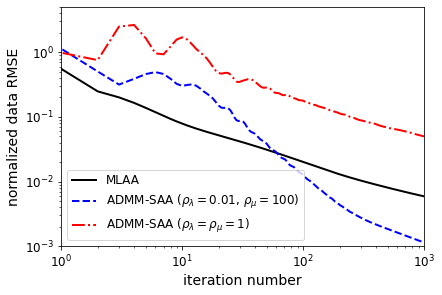

In [133]:
# reproducing Figure 3
figure(1,figsize=(6,4))
#mlaa data rmse
d1 = np.load("./results/mlaa_datarmse.npy")
#admm-saa data rmse
d2 = np.load("./results/saa_opt_datarmse.npy")
#admm-saa rho=1 data rmse
d3 = np.load("./results/saa_nonopt_datarmse.npy")

loglog(d1,"k-",linewidth=2.0,label="MLAA")
loglog(d2,"b--",linewidth=2.0,label=r"ADMM-SAA ($\rho_\lambda=0.01$, $\rho_\mu=100$)")
loglog(d3,"r-.",linewidth=2.0,label=r"ADMM-SAA ($\rho_\lambda=\rho_\mu=1$)")
xlabel("iteration number",fontsize=14)
ylabel("normalized data RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,1000,0.001,5])

legend(loc="lower left",fontsize=12)
subplots_adjust(left=0.13,bottom=0.14,top=0.97,right=0.97)


Next, we run ADMM-TVSAA with only the TV constraint on the activity map. The parameters used are $\rho_{\mu}=200$ and $\rho_{\lambda}=0.01$.

In [268]:
# output directory
resultsfile = './results/saa_lamTV_'

# TV-constraint parameters 
tvlamswitch = 1
tvmuswitch = 0
sbmu = 200 
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run saa-admm
for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()

   imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)
   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu *= mumask
   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
      ymuold = ymu*1.
      ymumin = ymunewt.min()
      ymu = ymunewt*1.
      ymu[ymu<0.] = 0.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 ==0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse"+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+".npy",array(attrmses))


iter:  0   1.5764592702675257   0.8985756831748288   1.0   2.8436079248564403
iter:  100   0.005845706753314701   0.07690737981021782   0.51550661549694   0.013728506028103982
iter:  200   0.0035008672032003506   0.04124254457391399   0.49577081034446996   0.008783756228738572
iter:  300   0.0028680485680776246   0.027726799938713076   0.48298348556846576   0.006957400214487109
iter:  400   0.002531826454823401   0.02135390843815714   0.47298791071237073   0.005853457665802557
iter:  500   0.00230197056626732   0.017634130855682082   0.4646984717585002   0.005093281887795782
iter:  600   0.0021248729795575144   0.015204696126325455   0.45762501779741654   0.004527890047880038
iter:  700   0.0019794756533828835   0.01344963573332764   0.4514783947345386   0.004090796168374429
iter:  800   0.001856159156615376   0.012096746624784657   0.44606736520538015   0.003740883927669591
iter:  900   0.0017496348698990076   0.011012761657473748   0.44125212128849267   0.0034524514610112284
iter:  1

We now run ADMM-TVSAA with only the TV constraint on the attenuation map. The parameters used are $\rho_{\mu}=100$ and $\rho_{\lambda}=0.01$.

In [277]:
# output directory
resultsfile = './results/saa_muTV_'

# parameters 
tvlamswitch = 0
tvmuswitch = 1
sbmu = 100 
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run saa-admm
for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()

   imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)
   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu *= mumask
   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
      ymuold = ymu*1.
      ymumin = ymunewt.min()
      ymu = ymunewt*1.
      ymu[ymu<0.] = 0.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 ==0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse"+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+".npy",array(attrmses))


iter:  0   1.5764592702675257   0.8985756831748288   1.0   2.8436079248564403
iter:  100   0.012635997932299805   0.05499565194478975   0.42047377377087153   0.015364795808729848
iter:  200   0.004915379135530606   0.029466383245865212   0.35683539936381453   0.009858850760134633
iter:  300   0.003278638384088152   0.022048998995342822   0.3081469229335041   0.007471248459157003
iter:  400   0.0025791620042239834   0.018046026579538202   0.26862479919812216   0.006021075492959309
iter:  500   0.0021359108961023594   0.0153205205383642   0.23600765235367205   0.005006812150394722
iter:  600   0.0018102679129771   0.013274016504017222   0.20887940559788096   0.0042331757193497625
iter:  700   0.0015575123541858322   0.011622862822192725   0.18611434103242894   0.0036122816510215944
iter:  800   0.001352365070103769   0.010245595988111452   0.1668638304370893   0.0031002171113701433
iter:  900   0.0011840791741038934   0.009066931255300227   0.15049652323163154   0.0026734491429473446
ite

Finally, we run ADMM-TVSAA with the TV constraints on both the activity and the attenuation map. Here, $\rho_{\lambda}=0.01$ amd $\rho_{\mu}=50$.

In [265]:
# output directory
resultsfile = './results/saa_bothTV_'

# parameters 
tvlamswitch = 1
tvmuswitch = 1
sbmu = 50 
sblambda = 0.01
sigmu = sbmu/lproj
taumu = 1.0/(sbmu*lproj)
siglambda = sblambda/ltofproj
taulambda = 1.0/(sblambda*ltofproj)

# initialization
worktofsino = 0.*tofsino
ulambda = 0.*tofsino
ylambda = 0.*tofsino

imlambda = testlambda*0.
wimlambda = testlambda*0.
ugradlamx = testlambda*0.
ygradlamx = testlambda*0.
ugradlamy = testlambda*0.
ygradlamy = testlambda*0.

worksino = 0.*sinoatt
umu = 0.*sinoatt
ymu = 0.*sinoatt
ugradmux = testlambda*0.
ygradmux = testlambda*0.
ugradmuy = testlambda*0.
ygradmuy = testlambda*0.

immu = testmu*0.
wimmu = testmu*0.

datarmses = []
imagelrmses = []
imagemrmses = []
attrmses = []
storeiterations=[1,2,5,10,20,50,100,200,500,1000]

# run saa-admm
for j in range(niter):
# x-update
   TOFprojection(imlambda,worktofsino)
   arg1 = ulambda+siglambda*(worktofsino -ylambda)
   TOFbackProjection(arg1,wimlambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam

   argx = ugradlamx + siglambda*(tgx - ygradlamx)
   argy = ugradlamy + siglambda*(tgy - ygradlamy)
   wgradimlam = mdiv(argx,argy)
   wgradimlam *= nulam*fovmask
   tvlamest  = sqrt(tgx**2 + tgy**2).sum()

   nu  = ((imlambda.sum() -ltotalcounts)/taulambda - wimlambda.sum() - wgradimlam)/fovmask.sum()

   imlambda =imlambda -taulambda*(nu*fovmask + wimlambda + wgradimlam)
   TOFprojection(imlambda,worktofsino)
   workgradlamx, workgradlamy = gradim(imlambda)
   workgradlamx *= nulam
   workgradlamy *= nulam


   circularParallelBeamProjection(immu,worksino)
   arg1 = umu +sigmu*( worksino -ymu )
   circularParallelBeamBackProjection(arg1,wimmu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   argx = ugradmux + sigmu*(tgx - ygradmux)
   argy = ugradmuy + sigmu*(tgy - ygradmuy)
   wgradimmu = mdiv(argx,argy)
   wgradimmu *= numu*fovmask
   immu =immu - wimmu*taumu - wgradimmu*taumu
   immu *= mumask
   circularParallelBeamProjection(immu,worksino)
   workgradmux, workgradmuy = gradim(immu)
   workgradmux *= numu
   workgradmuy *= numu

   tvmuest  = sqrt(tgx**2 + tgy**2).sum()

   ylambdat = 1.*ylambda
   ymut = 1.*ymu
# y-update
   aq = siglambda
   cq = -tofdata
   hessmin = 1.e10
   for k in range(nuv):
      ymuterm = ones([ntof])[:,newaxis,newaxis]*exp(-ymu)
      bq = ymuterm - ulambda - siglambda*worktofsino #  ylambdat or tofsino for test
      ylambdaold = ylambda*1.
      ylambda = (-bq + sqrt(bq*bq - 4.*aq*cq))/(2.*aq)
      ylambdaold = ylambda*1.

      ymunewt = ymu*0.
      for i in range(newtiter):
         grad = (-exp(-ymunewt)*ylambdaold + tofdata).sum(axis=0) - umu + sigmu*(ymunewt - worksino)
         ymuterm = ylambdaold*exp(-ymunewt)
         hess = ymuterm.sum(axis=0) + sigmu
         hessmin = minimum(hessmin,hess.min())
         ymunewt = ymunewt - grad/hess
      ymuold = ymu*1.
      ymumin = ymunewt.min()
      ymu = ymunewt*1.
      ymu[ymu<0.] = 0.
      ylambdadist = sqrt( ( (ylambda-ylambdaold)**2).sum())
      ymudist = sqrt( ( (ymu-ymuold)**2).sum())



   ptilx= ugradlamx/siglambda + workgradlamx
   ptily= ugradlamy/siglambda + workgradlamy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvlamswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvlambda)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradlamx = ptilx*1.
   ygradlamy = ptily*1.

   ptilx= ugradmux/sigmu + workgradmux
   ptily= ugradmuy/sigmu + workgradmuy
   ptilmag = sqrt(ptilx**2 + ptily**2)
   tempvex=(ptilmag).flatten()*1.
   if tvmuswitch:
      resvex = euclidean_proj_l1ball(tempvex, s=tvmu)
   else:
      resvex = tempvex*1.
   resvex.shape = nx,ny
   ptilx[ptilmag>0]=ptilx[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ptily[ptilmag>0]=ptily[ptilmag>0]*resvex[ptilmag>0]/ptilmag[ptilmag>0]
   ygradmux = ptilx*1.
   ygradmuy = ptily*1.

   
# u-update
   TOFprojection(imlambda,worktofsino)
   ulambda = ulambda + siglambda*(worktofsino - ylambda)
   tgx,tgy = gradim(imlambda)
   tgx *= nulam
   tgy *= nulam
   ugradlamx = ugradlamx + siglambda*(tgx - ygradlamx)
   ugradlamy = ugradlamy + siglambda*(tgy - ygradlamy)

   circularParallelBeamProjection(immu,worksino)
   umu = umu +sigmu*(worksino-ymu)
   tgx,tgy = gradim(immu)
   tgx *= numu
   tgy *= numu
   ugradmux = ugradmux + sigmu*(tgx - ygradmux)
   ugradmuy = ugradmuy + sigmu*(tgy - ygradmuy)


   attfactorest = exp(-worksino)
   datarmse = sqrt(( (tofdata-worktofsino*attfactorest)**2. ).sum())/sqrt( (tofdata**2).sum() )
   imagelrmse = sqrt(( (testlambda-imlambda)**2. ).sum())/sqrt( (testlambda**2.).sum() )
   imagemrmse = sqrt(( (testmu-immu)**2. ).sum())/sqrt( (testmu**2.).sum() )
   attdiff = (truess)*(attfactor -  attfactorest)
   attrmse = sqrt(( attdiff**2. ).sum())/sqrt( ((truess*attfactor)**2).sum() )
   datarmses.append(datarmse)
   imagelrmses.append(imagelrmse)
   imagemrmses.append(imagemrmse)
   attrmses.append(attrmse)
   if (j % 100 == 0):
       print("iter: ",j," ",datarmse," ",imagelrmse," ",imagemrmse," ",attrmse)

   if j+1 in storeiterations:
      save(resultsfile+"lambda"+str(j+1)+".npy",imlambda/datafactor) #save the images with datafactor removed in order to be able to compare with phantom
      save(resultsfile+"mu"+str(j+1)+".npy",immu)

save(resultsfile+"datarmse"+".npy",array(datarmses))
save(resultsfile+"imagelrmse"+".npy",array(imagelrmses))
save(resultsfile+"imagemrmse"+".npy",array(imagemrmses))
save(resultsfile+"attrmse"+".npy",array(attrmses))


iter:  0   1.5764592702675257   0.8985756831748288   1.0   2.8436079248564403
iter:  100   0.005054161709901349   0.02427304713775405   0.2961226314586648   0.006828997894767033
iter:  200   0.002002396200444614   0.01308020820034759   0.1787416155323679   0.003063423942008148
iter:  300   0.0011359977437213967   0.00885055998074988   0.11930237680412181   0.0017448037045606375
iter:  400   0.0007519615740070147   0.00630149376623104   0.08757192770435891   0.0010902545599847226
iter:  500   0.0005541041187372941   0.004657062112757214   0.06923604622771008   0.0007676252757696434
iter:  600   0.0004329188961488889   0.003603031105583149   0.05713943863724369   0.0005838030614031571
iter:  700   0.0003515626472202826   0.0028954925983938327   0.048334925319039636   0.00046732270910726135
iter:  800   0.0002933740392403676   0.0023915427586321757   0.04156661756219922   0.00038657908939685284
iter:  900   0.00024964057583159587   0.0020203684909586065   0.03618191042808723   0.000327930

We now collect the results from four settings (1) no TV constraints, (2) TV constraint on the attenuation map, (3) TV constraint on the activity map and (4) TV constraints on both maps. Plotting the normalized data RMSE versus iterations, we reproduce Figure 4.

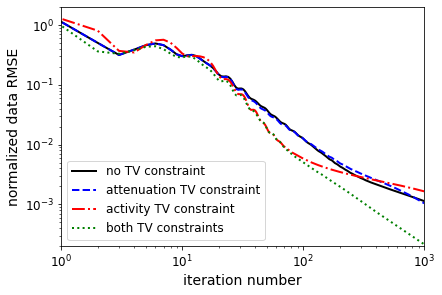

In [278]:
figure(1,figsize=(6,4))
#admm-saa data rmse
d1 = np.load("./results/saa_opt_datarmse.npy")
#admm-saa lmu TV
d2 = np.load("./results/saa_muTV_datarmse.npy")
#admm-saa lambda TV
d3 = np.load("./results/saa_lamTV_datarmse.npy")
#admm-saa both TV consts.
d4 = np.load("./results/saa_bothTV_datarmse.npy")

loglog(d1,"k-",linewidth=2.0,label="no TV constraint")
loglog(d2,"b--",linewidth=2.0,label="attenuation TV constraint")
loglog(d3,"r-.",linewidth=2.0,label="activity TV constraint")
loglog(d4,"g:",linewidth=2.0,label="both TV constraints")
xlabel("iteration number",fontsize=14)
ylabel("normalized data RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,1000,0.0002,2])

legend(loc="lower left",fontsize=12)
subplots_adjust(left=0.13,bottom=0.14,top=0.97,right=0.97)

The following plots the normalized activity RMSE versus iterations and reproduces Figure 5.

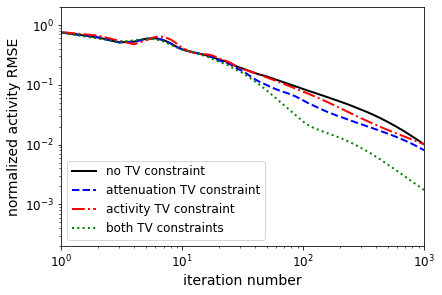

In [279]:
figure(1,figsize=(6,4))
#admm-saa data rmse
d1 = np.load("./results/saa_opt_imagelrmse.npy")
#admm-saa mu TV
d2 = np.load("./results/saa_muTV_imagelrmse.npy")
#admm-saa lambda TV
d3 = np.load("./results/saa_lamTV_imagelrmse.npy")
#admm-saa both TV consts.
d4 = np.load("./results/saa_bothTV_imagelrmse.npy")

loglog(d1,"k-",linewidth=2.0,label="no TV constraint")
loglog(d2,"b--",linewidth=2.0,label="attenuation TV constraint")
loglog(d3,"r-.",linewidth=2.0,label="activity TV constraint")
loglog(d4,"g:",linewidth=2.0,label="both TV constraints")
xlabel("iteration number",fontsize=14)
ylabel("normalized activity RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,1000,0.0002,2])

legend(loc="lower left",fontsize=12)
subplots_adjust(left=0.13,bottom=0.14,top=0.97,right=0.97)

The following plots the normalized attenuation factor RMSE versus iterations and reproduces Figure 6.

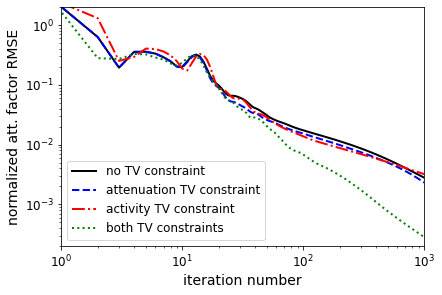

In [280]:
figure(1,figsize=(6,4))
#admm-saa data rmse
d1 = np.load("./results/saa_opt_attrmse.npy")
#admm-saa mu TV
d2 = np.load("./results/saa_muTV_attrmse.npy")
#admm-saa lambda TV
d3 = np.load("./results/saa_lamTV_attrmse.npy")
#admm-saa both TV consts.
d4 = np.load("./results/saa_bothTV_attrmse.npy")

loglog(d1,"k-",linewidth=2.0,label="no TV constraint")
loglog(d2,"b--",linewidth=2.0,label="attenuation TV constraint")
loglog(d3,"r-.",linewidth=2.0,label="activity TV constraint")
loglog(d4,"g:",linewidth=2.0,label="both TV constraints")
xlabel("iteration number",fontsize=14)
ylabel("normalized att. factor RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,1000,0.0002,2])

legend(loc="lower left",fontsize=12)
subplots_adjust(left=0.13,bottom=0.14,top=0.97,right=0.97)

Now we plot the normalized attenuation RMSE versus iterations and reproduce Figure 7.

In [ ]:
figure(1,figsize=(6,4))
#admm-saa data rmse
d1 = np.load("./results/saa_opt_imagemrmse.npy")
#admm-saa lambda TV
d3 = np.load("./results/saa_muTV_imagemrmse.npy")
#admm-saa lambda TV
d3 = np.load("./results/saa_lamTV_imagemrmse.npy")
#admm-saa both TV consts.
d4 = np.load("./results/saa_bothTV_imagemrmse.npy")

loglog(d1,"k-",linewidth=2.0,label="no TV constraint")
loglog(d2,"b--",linewidth=2.0,label="attenuation TV constraint")
loglog(d3,"r-.",linewidth=2.0,label="activity TV constraint")
loglog(d4,"g:",linewidth=2.0,label="both TV constraints")
xlabel("iteration number",fontsize=14)
ylabel("normalized att. RMSE",fontsize=14)
xticks(fontsize=12)
yticks(fontsize=12)
axis([1,1000,0.0002,2])

legend(loc="lower left",fontsize=12)
subplots_adjust(left=0.13,bottom=0.14,top=0.97,right=0.97)

The following plots the recovered attenuation maps from the four versions of our method ater the 1000-th iteration, and reproduces Figure 8.

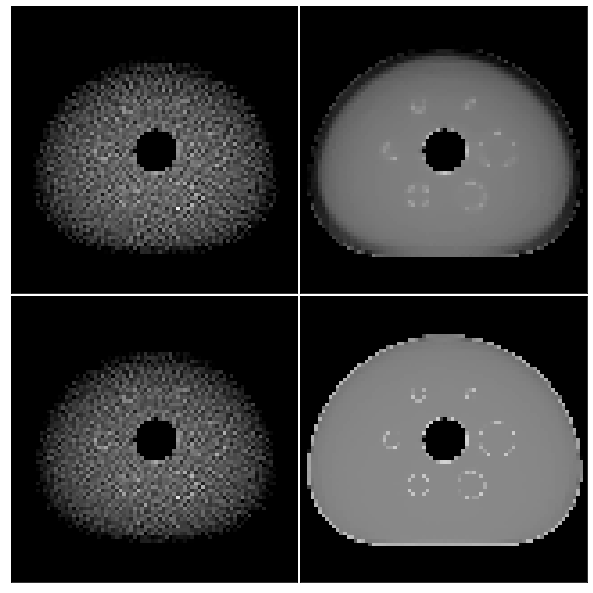

In [282]:
im1 = np.load("./results/saa_opt_mu1000.npy")
im2 = np.load("./results/saa_muTV_mu1000.npy")
im3 = np.load("./results/saa_lamTV_mu1000.npy")
im4 = np.load("./results/saa_bothTV_mu1000.npy")

vmm= 0.075
vmx= 0.115
figure(1,figsize=(8,8))
subplot(221)
imshow(im1[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(222)
imshow(im2[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(223)
imshow(im3[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplot(224)
imshow(im4[24:104,24:104],vmin = vmm, vmax = vmx, cmap = cm.gray, interpolation = "nearest")
xticks([])
yticks([])
subplots_adjust(left = 0, bottom = 0,top = 1,right= 1,wspace =0.01,hspace = 0.01)
